### Visualizations

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from sklearn.preprocessing import MinMaxScaler
import matplotlib.gridspec as gridspec


Extract tasks names from folders

In [3]:
#Label function def
# Mapping featsel to a short label for the x-axis
featsel_map = {
    'hvg': 'h',
    'hvg_svd': 'hs',
    'hvg_svd_graph': 'hsg',
    'svd': 's',
    'svd_graph': 'sg',
    'hvg_nomsi': 'hvg_nomsi'
}

def get_method_label(method_name, featsel, method_params):
    featsel_short = featsel_map.get(featsel, featsel)
    
    if isinstance(method_params, str):
        method_params = eval(method_params)
        
    if not method_params or not isinstance(method_params, dict):
        return f"{method_name}\n{featsel_short}"
    
    param_parts = [f"{k}={v}" for k, v in method_params.items()]
    param_parts = param_parts[:2]
    param_str = "\n".join(param_parts)
    
    return f"{method_name}\n{param_str}\n{featsel_short}"

In [4]:
reports_path = "/lustre/groups/ml01/workspace/eirini/pipeline/data/reports"

#Get all tasks names
task_names = sorted([name for name in os.listdir(reports_path) if os.path.isdir(os.path.join(reports_path, name))])
print("Available tasks:")
for task in task_names:
    print(task)


Available tasks:
V11L12-038_A1_MOSCOT_paired_hvg_top10_spatvar
V11L12-038_A1_MOSCOT_paired_hvg_top20_spatvar
V11L12-038_A1_MOSCOT_paired_hvg_top5_spatvar
lipids
lipids_spatialy_highly_variable
lipids_top10_spatvar
lipids_top20_spatvar
lipids_top5_spatvar
neuro
neuro_spatialy_highly_variable
neuro_top10_spatvar
neuro_top20_spatvar
neuro_top5_spatvar
neurotransmitters_spatialy_highly_variable
pca_msi_V11L12-038
pca_msi_lipids
pca_msi_neuro
vitatrack


Select task and extract appropriate merged_results.tsv (considering that merged_results was produced while running all avail models, else you can scrape the dir and extract the wished information)

In [5]:
task = "vitatrack"
merged = pd.read_csv(f"{reports_path}/{task}/merged_results.tsv", sep="\t")

In [6]:
merged.head()
merged = merged.drop_duplicates()


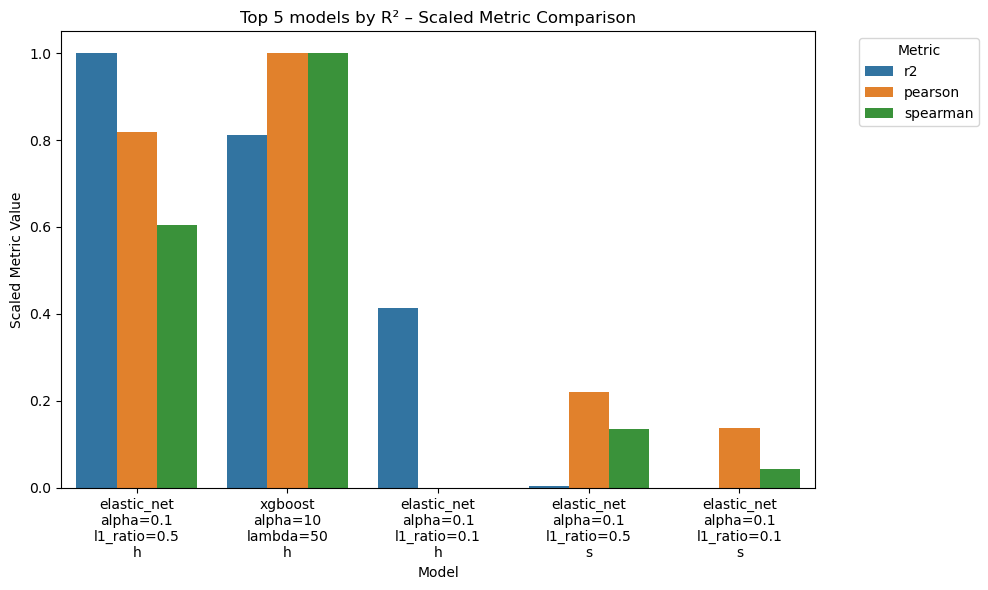

In [7]:
# Select top 5 rows by highest R²
top5 = merged.sort_values("r2", ascending=False).head(5).reset_index(drop=True)

# Keep only metric columns (not meta info like task or hash)
metrics = ["r2", "pearson", "spearman"] #"rmse", "mae", 

# Normalize each metric to [0, 1] range for comparison
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(top5[metrics]), columns=metrics)

scaled["model"] = [
    get_method_label(row["method_name"], row["featsel"], row["method_params"])
    for _, row in top5.iterrows()
]
raw_r2 = top5["r2"].values

# Reshape for plotting
melted = scaled.melt(id_vars="model", var_name="metric", value_name="value")

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x="model", y="value", hue="metric")
plt.title("Top 5 models by R² – Scaled Metric Comparison")
plt.ylabel("Scaled Metric Value")
plt.xlabel("Model")
plt.xticks(rotation=0, ha="center")
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Let's create Pearson vs. Spearman plots for each method

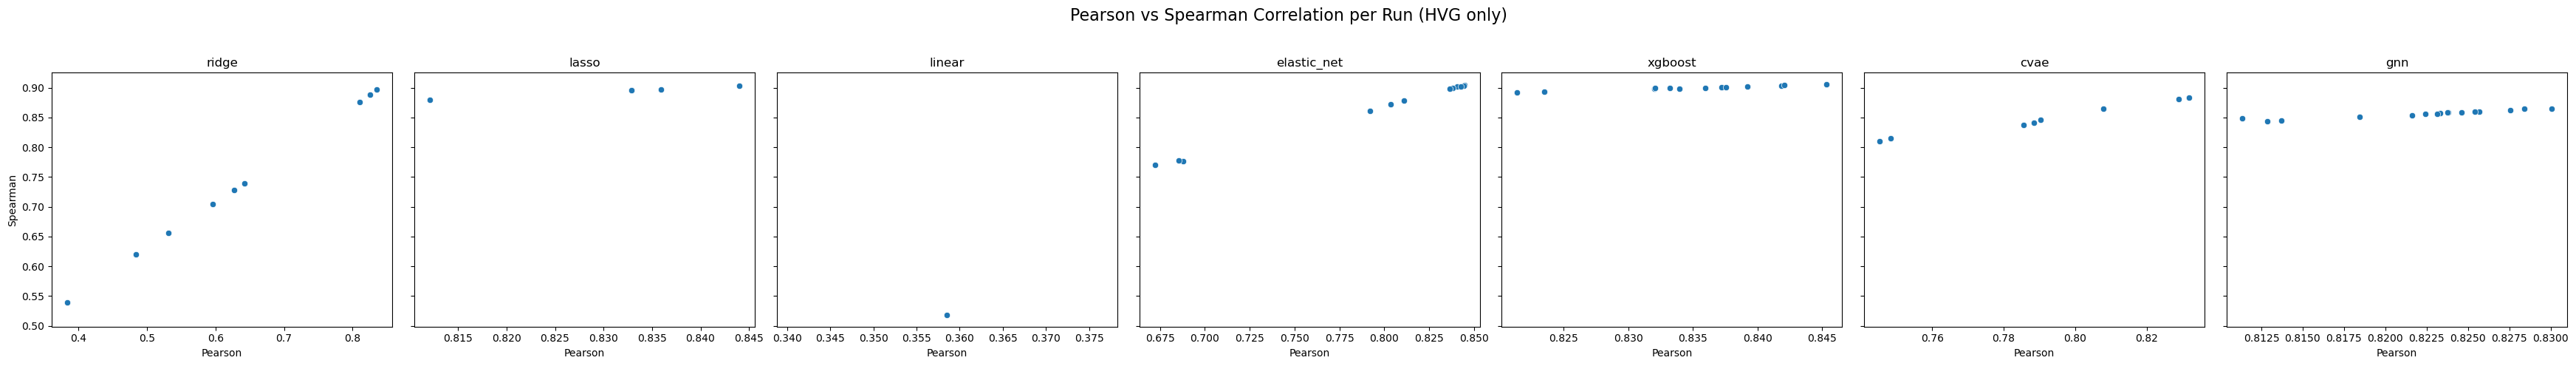

In [8]:
task = "vitatrack"
df = pd.read_csv(f"{reports_path}/{task}/merged_results.tsv", sep="\t")
df = df.drop_duplicates()

# Keep only featsel == hvg 
df = df[(df["featsel"] == "hvg")]

# Get unique methods
methods = df["method_name"].unique()

# Set up subplots
n_methods = len(methods)
fig, axes = plt.subplots(1, n_methods, figsize=(5 * n_methods, 5), sharey=True)

# If only one method, wrap axes in a list
if n_methods == 1:
    axes = [axes]

for i, method in enumerate(methods):
    subset = df[df["method_name"] == method]
    sns.scatterplot(data=subset, x="pearson", y="spearman", ax=axes[i])
    axes[i].set_title(f"{method}")
    axes[i].set_xlabel("Pearson")
    if i == 0:
        axes[i].set_ylabel("Spearman")
    else:
        axes[i].set_ylabel("")

plt.suptitle("Pearson vs Spearman Correlation per Run (HVG only)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Heatmap of metrics correlations

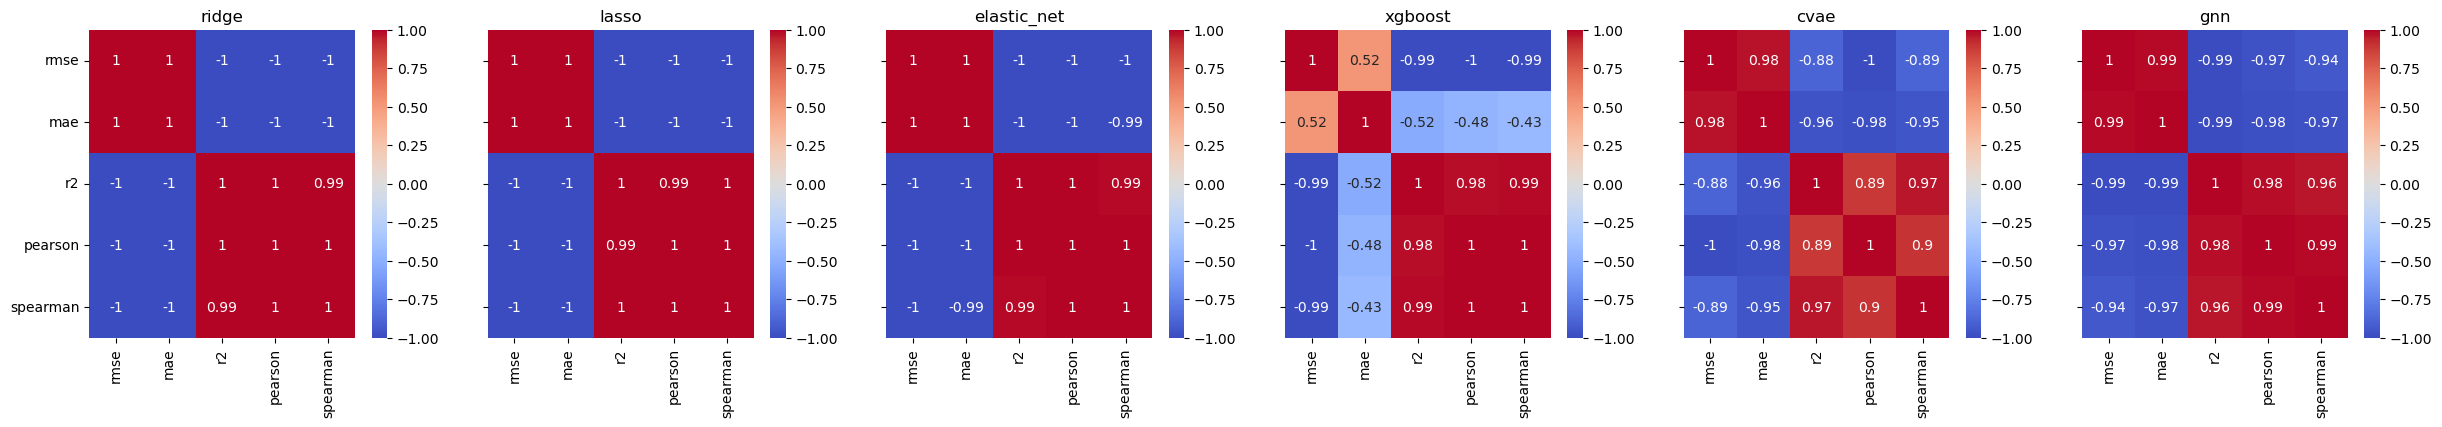

In [9]:
task = "lipids"
df = pd.read_csv(f"{reports_path}/{task}/merged_results.tsv", sep="\t")
df = df.drop_duplicates()
df = df[(df["featsel"] == "hvg") & (~df["method_name"].isin(["linear"]))]

# df = df[(df["featsel"] == "hvg") &
#         (~df["method_name"].isin(["linear"])) &
#         (df["r2"] > 0)]

methods = df["method_name"].unique()

# Plot one heatmap per method
n = len(methods)
fig, axes = plt.subplots(1, n, figsize=(5 * n, 4), sharey=True)

# Metrics to use
metric_cols = ["rmse", "mae", "r2", "pearson", "spearman"]

for i, method in enumerate(methods):
    subset = df[df["method_name"] == method][metric_cols]
    
    if subset.shape[0] < 2:
        axes[i].text(0.5, 0.5, "No valid runs", ha="center", va="center", fontsize=12)
        axes[i].set_title(f"{method} (skipped)")
        axes[i].axis("off")
        continue
    
    corr = subset.corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=axes[i])
    axes[i].set_title(method)



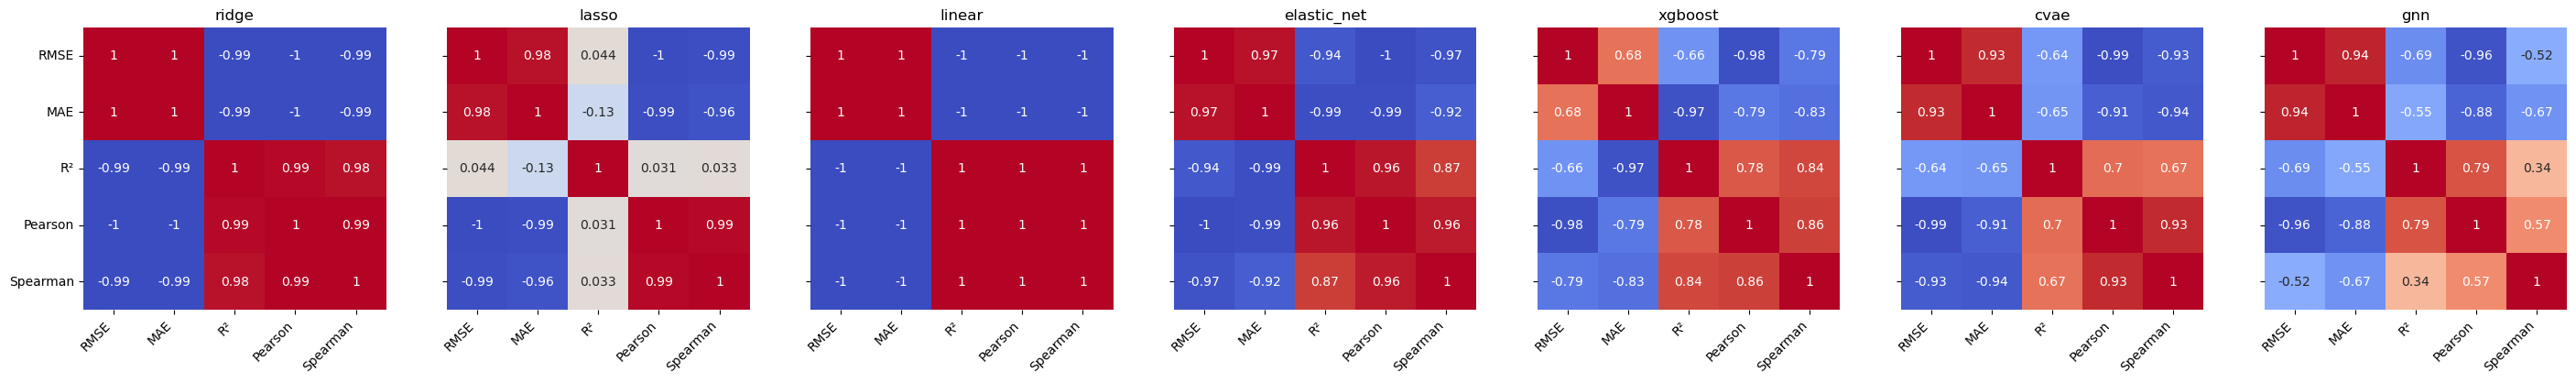

In [10]:
# Load and filter data
task = "neuro"
df = pd.read_csv(f"{reports_path}/{task}/merged_results.tsv", sep="\t")
df = df.drop_duplicates()
#df = df[(df["featsel"] == "hvg") & (~df["method_name"].isin(["linear", "ridge"])) & (df["r2"] > 0)]
# df = df[df["r2"] > 0]


methods = df["method_name"].unique()
n = len(methods)

# Metrics and pretty labels
metric_cols = ["rmse", "mae", "r2", "pearson", "spearman"]
pretty_metric_labels = {
    "rmse": "RMSE", "mae": "MAE", "r2": "R²", "pearson": "Pearson", "spearman": "Spearman"
}
metric_labels_ordered = [pretty_metric_labels[m] for m in metric_cols]
# Plot one heatmap per method
fig, axes = plt.subplots(1, n, figsize=(5 * n, 4), sharey=True)

# Plot heatmaps
for i, method in enumerate(methods):
    subset = df[df["method_name"] == method][metric_cols]
    corr = subset.corr()
    
    # Apply pretty labels
    corr.index = corr.index.map(pretty_metric_labels)
    corr.columns = corr.columns.map(pretty_metric_labels)

    sns.heatmap(
        corr, 
        annot=True, 
        cmap="coolwarm", 
        vmin=-1, vmax=1, 
        ax=axes[i], 
        cbar=False
    )
    axes[i].set_title(method)
    axes[i].set_xticklabels(corr.columns, rotation=45, ha="right")
    axes[i].set_yticklabels(corr.index, rotation=0)

In [11]:
df.groupby("method_name")["mae"].std()


method_name
cvae           0.052176
elastic_net    0.038251
gnn            0.033210
lasso          0.003003
linear         0.299198
ridge          0.185402
xgboost        0.014062
Name: mae, dtype: float64

In [12]:
df[df["method_name"] == "xgboost"]

,rmse,mae,r2,pearson,spearman,task,method_name,featsel,method_params,hash
140,0.437339,0.265414,-0.000576,0.901912,0.518410,neuro,xgboost,hvg,"{'alpha': 50, 'lambda': 100, 'max_depth': 3, '...",918294c90c
141,0.438335,0.262834,-0.006731,0.901635,0.516623,neuro,xgboost,hvg,"{'alpha': 10, 'lambda': 50, 'max_depth': 5, 'l...",fea98a1406
142,0.439062,0.262710,-0.006837,0.900871,0.516203,neuro,xgboost,hvg,"{'alpha': 30, 'lambda': 80, 'max_depth': 4, 'l...",a481e94db2
143,0.452990,0.275063,-0.075762,0.894817,0.508117,neuro,xgboost,hvg,"{'alpha': 0, 'lambda': 10, 'max_depth': 6, 'le...",f75295e8a6
144,0.438199,0.262311,-0.004101,0.901451,0.517051,neuro,xgboost,hvg,"{'alpha': 30, 'lambda': 85, 'max_depth': 4, 'l...",2c14c3661f
...,...,...,...,...,...,...,...,...,...,...
200,0.417723,0.267110,-0.032830,0.906933,0.518857,neuro,xgboost,svd_graph,"{'alpha': 5, 'lambda': 30, 'max_depth': 6, 'le...",5dd20f859a
201,0.413603,0.264739,-0.012967,0.908961,0.529794,neuro,xgboost,svd_graph,"{'alpha': 45, 'lambda': 95, 'max_depth': 3, 'l...",f43dd54b06
202,0.471268,0.322780,-0.336962,0.884188,0.483587,neuro,xgboost,svd_graph,"{'alpha': 0, 'lambda': 0, 'max_depth': 4, 'lea...",7dbe0470e8
203,0.416586,0.262654,-0.025891,0.907272,0.522773,neuro,xgboost,svd_graph,"{'alpha': 25, 'lambda': 75, 'max_depth': 5, 'l...",4b99c52c18


In [13]:
import scanpy as sc

/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/yufan.xia/tools/apps/mamba/envs/

In [15]:
import squidpy as sq

/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/icb/yufan.xia/tools/apps/mamba/envs/pipeline/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [14]:
adata_rna = sc.read_h5ad("/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/vitatrack/datasets/V11L12-038_A1.RNA_MOSCOT_paired_hvg.h5ad")

In [16]:
adata_rna

AnnData object with n_obs × n_vars = 2681 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'mt_frac', 'total_counts', 'n_counts', 'n_genes', 'clusters', 'technology', 'split'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'technology'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'raw_counts', 'spatial', 'spatial_warp'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [25]:
sq.gr.spatial_neighbors(adata_rna, coord_type="generic")  # assumes obsm["spatial"]
adata_rna.uns["moranI"]

,I,pval_norm,var_norm,pval_norm_fdr_bh
Penk,0.752875,0.000000,0.000139,0.000000
Nrgn,0.709952,0.000000,0.000139,0.000000
Slc17a7,0.683989,0.000000,0.000139,0.000000
Gm42418,0.681824,0.000000,0.000139,0.000000
Cck,0.650221,0.000000,0.000139,0.000000
...,...,...,...,...
Rps6kc1,-0.023125,0.026651,0.000139,0.064608
Thap12,-0.023430,0.025092,0.000139,0.061274
L2hgdh,-0.024322,0.020967,0.000139,0.052028
Cwc25,-0.025214,0.017434,0.000139,0.043914


In [ ]:
sq.pl.spatial_scatter(adata_rna, color=genes, ncols=1)


In [ ]:
spatial_hvg = adata_rna.uns['moranI'][:2000].index.values
spatial_hvg

array(['Penk', 'Nrgn', 'Slc17a7', ..., 'L2hgdh', 'Cwc25', 'Ift80'],
      dtype=object)

In [20]:
len(spatial_hvg)

2000

In [ ]:
hvg = adata_rna[:,adata_rna.var['highly_variable']].var.index.values
len(set(spatial_hvg).difference(set(hvg)))

0

In [ ]:
differet_hvgs = set(spatial_hvg).difference(set(hvg))
genes = adata_rna.uns['moranI'].loc[list(differet_hvgs)].sort_values('I')[-10:].index.values
